# Detect Person of Interest in the Fraud in Enron Scandal.

## Project Overview
Enron was an energy, commodities, and services company based in Houston, Texas. It was founded in 1985. Enron was one of the world's major energy companies and was named "America's Most Innovative Company" for six consecutive years by Fortune. October 2001, it was revealed that Enron's reported financial condition was actually planned accounting fraud. Jeffrey Skilling developed a staff of executives to hide billions of dollars in debt from failed deals and projects. They even pressured the "Arthur Andersen", one of the "Big Five" accounting firm at that time, to ignore the issues. The publicized of Enron scandal eventually led to the bankruptcy of the Enron Corporation and ultimately destroyed Arthur Andersen [[1](https://en.wikipedia.org/wiki/Enron), [2](https://en.wikipedia.org/wiki/Enron_scandal), [3](https://en.wikipedia.org/wiki/Arthur_Andersen#Demise)]. 

The email data and financial records of many executives was made public by the Federal Energy Regulatory Commission during its investigation [[4](http://fch808.github.io/Identifying_Fraud_at_Enron.html#fn:enron_pdf), [5](http://news.findlaw.com/legalnews/lit/enron/)]. In this project, I will use machine learning to identify the cirtical features determining the person involved in the Enron Scandal (person of interested) based on the email data and financial records. 

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# functions used for the test in Udacity project examination
import sys
import pickle
sys.path.append("../tools/")
from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data

# machine learning scikit-learn
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn import linear_model, decomposition, datasets
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV
from sklearn import linear_model, decomposition, datasets
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score



/Users/hsinfang/anaconda2/envs/DAND/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/hsinfang/anaconda2/envs/DAND/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


# Import Data

In [18]:
## Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)
    
#@ show all feature names:
# data_dict[data_dict.keys()[0]].keys()

## convert to data frame for easier exploration
dataT = [data_dict[data_dict.keys()[x]] for x in range(0,len(data_dict))]
df = pd.DataFrame(dataT, index = data_dict.keys())
df = df.replace('NaN',np.nan)

# Data Overview
## Valid data entries 

In [19]:
# convert poi to 0 (False) and 1(True)
df.loc[df['poi'] == False, 'poi'] = int(0)
df.loc[df['poi'] == True, 'poi'] = int(1)
## First see how many valid entries in every feature
print "We have lots of missing numbers"
print "Moreover, we have", len(df) - sum(df.isnull().any(axis=1)), 'people with completed data in all fields'
print 
print
df.info()

We have lots of missing numbers
Moreover, we have 0 people with completed data in all fields


<class 'pandas.core.frame.DataFrame'>
Index: 146 entries, METTS MARK to GLISAN JR BEN F
Data columns (total 21 columns):
bonus                        82 non-null float64
deferral_payments            39 non-null float64
deferred_income              49 non-null float64
director_fees                17 non-null float64
email_address                111 non-null object
exercised_stock_options      102 non-null float64
expenses                     95 non-null float64
from_messages                86 non-null float64
from_poi_to_this_person      86 non-null float64
from_this_person_to_poi      86 non-null float64
loan_advances                4 non-null float64
long_term_incentive          66 non-null float64
other                        93 non-null float64
poi                          146 non-null bool
restricted_stock             110 non-null float64
restricted_stock_deferred    18 non-null float64
s

## Valid entries in poi and non-poi

In [20]:
print "There are", len(df[df['poi']==1]), "poi"
print "And", len(df[df['poi']==0]), "non-poi"
print "Here is the number of valid entries in each field:"
non_poi_valid_data = pd.DataFrame(len(df[df['poi']==0]) - df[df['poi'] == 0].isnull().sum(), columns=['non-poi'])
poi_valid_data = pd.DataFrame(len(df[df['poi']==1]) - df[df['poi']== 1].isnull().sum(), columns=['poi'])
pd.concat([non_poi_valid_data, poi_valid_data], axis=1) 

There are 18 poi
And 128 non-poi
Here is the number of valid entries in each field:


,non-poi,poi
bonus,66,16
deferral_payments,34,5
deferred_income,38,11
director_fees,17,0
email_address,93,18
exercised_stock_options,90,12
expenses,77,18
from_messages,72,14
from_poi_to_this_person,72,14
from_this_person_to_poi,72,14


** As you can see, we have lots of missing data. I think it would make more sense to use only features with more than half valid entries. The "email_address" alone cannot tell us anything so I also droped it. We will get more information about the interaction with poi from the amount of emails the send to each others.**

## Features with more than half valid entries, in poi and non-poi

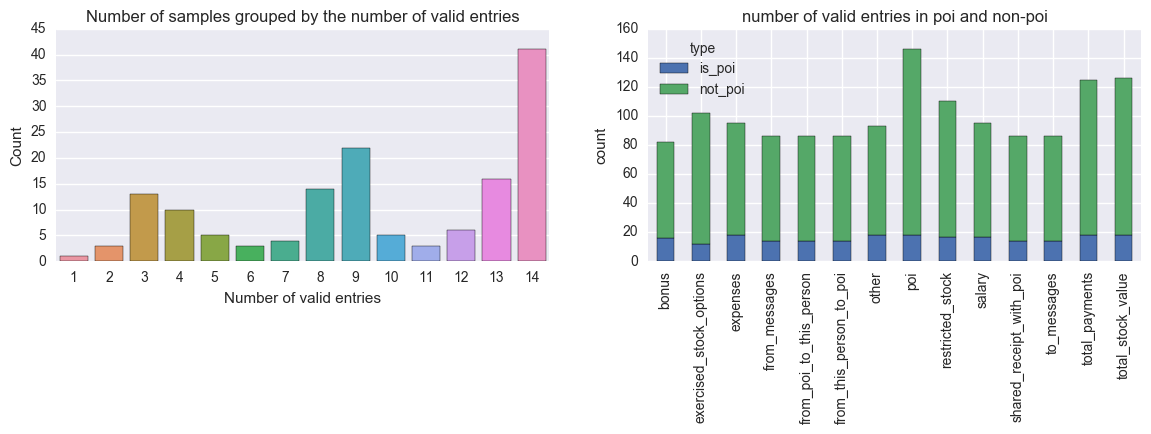

In [21]:
# Remove features with less than half valid entries
df = df.loc[:,df.isnull().sum(axis=0)<=len(df)/2.]
# drop email_address
df = df.drop('email_address', axis=1)
# Find the number of valid entries in the sample
num_completed_sample = pd.DataFrame(len(df.columns)-df.isnull().sum(axis=1)).reset_index().groupby(0).count().reset_index().rename(columns={0:'num_valid_entry','index':'Count'})
# num_completed_sample = num_completed_sample.sort_values(by='num_valid_entry', ascending=False)

## plot number of valid entries in the sample
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,3))
g = sns.barplot(x='num_valid_entry',y='Count',data=num_completed_sample, ax = ax1)
g.set(title="Number of samples grouped by the number of valid entries", 
      xlabel="Number of valid entries", ylabel="Count");

## plot number of valid entries in the rest fields for poi and non-poi
num_valid_feature_poiT = len(df[df['poi']==1]) - df[df['poi']==1].isnull().sum(axis=0)
num_valid_feature_poiF = len(df) - df.isnull().sum(axis=0) - num_valid_feature_poiT
num_valid_feature_poiT = num_valid_feature_poiT.reset_index().rename(columns={"index":"fields",0:"count"})
num_valid_feature_poiF = num_valid_feature_poiF.reset_index().rename(columns={"index":"fields",0:"count"})
num_valid_feature_poiF['type']='not_poi'
num_valid_feature_poiT['type']='is_poi'
poi_num = pd.concat([num_valid_feature_poiT,num_valid_feature_poiF])
g = poi_num.pivot('fields', 'type')['count'].plot(kind='bar', stacked=True, ax = ax2)
g.set(ylabel='count', xlabel='', title='number of valid entries in poi and non-poi');

** As you can see from the left figure, 41 samples have full data in the 14 fields. 16 samples have full data in 13 of these 14 fields. The right figure shows that every field has more than 50% of samples from poi and non-poi having vaild entries. Therefore, I would chose these features for now and start to remove outlier.**

``` python
g = sns.PairGrid(df, hue="poi")
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter)
g.add_legend();
```

Examination of the relation between each pair of features I found there is one extreme value in many plots. Let's have a look at what's that.

## Outlier Investigation

In [22]:
## remove outlier, the max value
rm_id = list(df["expenses"]).index(max(df["expenses"]))
rm_name = df.index[rm_id]
print rm_name
df.iloc[rm_id, :]

TOTAL


bonus                      9.73436e+07
exercised_stock_options    3.11764e+08
expenses                    5.2352e+06
from_messages                      NaN
from_poi_to_this_person            NaN
from_this_person_to_poi            NaN
other                      4.26676e+07
poi                              False
restricted_stock           1.30322e+08
salary                     2.67042e+07
shared_receipt_with_poi            NaN
to_messages                        NaN
total_payments             3.09887e+08
total_stock_value           4.3451e+08
Name: TOTAL, dtype: object

In [23]:
# remove travel angency
i = 0
for x in df.index.str.findall('TRAVEL'):
    if len(x)>0:
        q = i
        print i, x
    i += 1
df.iloc[q, :]

101 ['TRAVEL']


bonus                         NaN
exercised_stock_options       NaN
expenses                      NaN
from_messages                 NaN
from_poi_to_this_person       NaN
from_this_person_to_poi       NaN
other                      362096
poi                         False
restricted_stock              NaN
salary                        NaN
shared_receipt_with_poi       NaN
to_messages                   NaN
total_payments             362096
total_stock_value             NaN
Name: THE TRAVEL AGENCY IN THE PARK, dtype: object

** The extrem value is actually TOTAL of each column. Even though many fields show many extreme values, we don't hav evdience showing that these exterme values were  produced by different process as the rest of the data. Therefore, I just removed the row of "TOTAL" and kept the rest.  **

In [24]:
# Remove TOTAL
df = df.drop(df.index[rm_id])
# Remove travel angency
df = df.drop(df.index[q])

# # Look at those relations again
# g = sns.PairGrid(df, hue="poi")
# g.map_diag(plt.hist)
# g.map_offdiag(plt.scatter)
# g.add_legend();
# g.savefig("clean.png")

** To further validate the removal of outliers, let's look at an extreme point in "total_payments"**

In [25]:
id_strange = list(df['total_payments']).index(max(df['total_payments']))
df.iloc[id_strange, ]

bonus                            7e+06
exercised_stock_options    3.43484e+07
expenses                         99832
from_messages                       36
from_poi_to_this_person            123
from_this_person_to_poi             16
other                      1.03597e+07
poi                               True
restricted_stock           1.47617e+07
salary                     1.07232e+06
shared_receipt_with_poi           2411
to_messages                       4273
total_payments              1.0356e+08
total_stock_value          4.91101e+07
Name: LAY KENNETH L, dtype: object

** The extereme actually point out the poi, "LAY KENNETH", the founder of Enron. As poi are quite rare cases in our data (18 out of 146), remove extreme values (i.e., outliers) without solid support is not a good idea.**

## Create new features
To consider the relation between someone and poi, it makes more sense to consider how many **percentage** of emails from/to the person is to/from poi instead of looking at the total amount of emails. Therefore, I will create **to_poi** using "from_poi_to_this_person/to_messages" and **from_poi** using "from_this_person_to_poi/from_messages".

In [26]:
# create new features
df['to_poi'] = df['from_this_person_to_poi']/df['from_messages'].astype(float)
df['from_poi'] = df['from_poi_to_this_person']/df['to_messages'].astype(float)
# set those "to_messages" or "to_messages" equals 0 to 0:
df['to_poi'] = df['to_poi'].fillna(0.)
df['from_poi'] = df['from_poi'].fillna(0.)
# sns.distplot(df.to_poi)
# sns.distplot(df.from_poi)

# remove old features
df = df.drop(['from_this_person_to_poi','from_poi_to_this_person','to_messages','from_messages'], axis=1)
df[['to_poi','from_poi']].describe()

,to_poi,from_poi
count,145.000000,145.000000
mean,0.109164,0.022516
std,0.185513,0.036339
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.004885
75%,0.198436,0.029817
max,1.000000,0.217341


**As there are so few poi, it turns out that the percentage of emails to/from poi are always small.**

## Replace all NA with the median value in that feature

In [27]:
# replace na with median
df = df.fillna(df.median())

## Scale Features
** Feature scaling is essential in most machine algorithms besides Linear regression and Decision Tree. But if gradient descend is applied to increase the speed then it's very important to scale the features so that the gradient descend can properly find the global minimum. In this case I have few features (N around 10) and samples (N = 146) so I don't need gradient descend. However, I will also try SVM so I will scale my features so that the data set can be applied to all the alogorithms I try. **

In [28]:
# process the data to array
target = df.poi.as_matrix()
features = df.drop('poi', axis=1).as_matrix()

# scale features
# from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)

## Select Features
**I will use "SelectKBest" to look at the score of each feature. This will be the guideline for selected features to run machine learning. Here I show the result from both SelectKBest and DecisionTree. However, I removed it in the workflow below as DecisionTree changes the results everytime, making the results irreproducible. The function `select_features` based on SelectKBest will be used below for systematically find the best number of feature to used finally.**

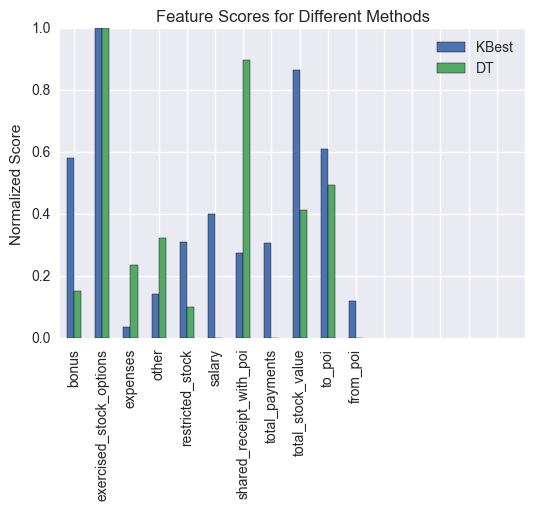

In [29]:
from sklearn.feature_selection import SelectKBest
from sklearn.tree import DecisionTreeClassifier
nf = len(features[1])
# SelectKBest
sel = SelectKBest(k = 9)
sel.fit(features, target)
score_kBest = sel.scores_.reshape(nf, 1)

#Decision Tree
clf = DecisionTreeClassifier()
clf.fit(features, target)
score_DT = clf.feature_importances_.reshape(nf, 1)

# put the scores into a dataframe
score_kBest = pd.DataFrame(score_kBest).rename(columns={0:"KBest"})
score_DT = pd.DataFrame(score_DT).rename(columns={0:"DT"})
pd_score = pd.concat([score_kBest,score_DT], axis=1)

# plot the scores from different methods
pd_score = pd_score/pd_score.max()
pd_score.plot.bar(stacked=False);
plt.xticks(np.arange(17), list(df.drop('poi',axis=1).columns));
plt.ylabel("Normalized Score")
plt.title("Feature Scores for Different Methods");



**I normalized the score for different methods (  $\mathrm{S_i}/\mathrm{Max(S_i)}$, where S = score and i = SelectKBest or DecisionTree) so that they can be better compared/seen side by side.**

## Machine Learning Classifier
### Importance of parameter tuning
Machine learning uses different classifiers to find some structures in the data and then make prediction. Different classifiers have different parameters that help them to better capture the data structure so it's important to use the right parameters when we choose the classifier. For example, decision tree classifier continues split the data into different groups. If parameters like min_samples_split are not properly selected, the classifer will make too delicate decision boundries and overfit the data. Below I will list the classifer I am going to use and how I choose the corresponding parameters.  

### Classifier used
* I will use **Gaussian Naive Bayes**, **SVM**, **DecisionTree**, **RandomForest** and **PCA/LogisticRegression pipeline**
* First the parameters of each classiflier will be exaplained
* Then a systematic parameters search will fine the best parameters for each classifiler 
* The accuracy will be compared among these 4 classifilers
* Finally these 4 classifier will be validated


#### Gaussian Naive Bayes: no parameter
#### SVM: 
1. use rbf as kernel, which has a form like: 
$$\frac{1}{exp^{\gamma |x-x'|}}$$
x is data point from training set and x' is the unlabeled data point.
To decide which group the unlabeled point belongs, it computes
$$\mathrm{sgn} \sum_{i=1}^N (y_i)\alpha_iK(x_i-x')+\rho $$
2. Gamma would be the influence of of each training point. A large gamma means a short range of influence so the prediction would be very localized around training data (like dots) instead of an extended field. 
    * I would starts with the default value (`1/num of features)` and run a systematical search covering that value, as it's not intuitive to get a precise value in this case.
3. C is `n_samples/alpha`. According to the decision equation, a lager C would lead to effects similar to large gamma. Usually C is called the panelty of wrong classification so a small C would lead to a smooth decision boundary.
    * The same as gamma, I would systematically search for the best value covering the default value (1).

#### DecisionTree
Two main parameters considered here:
1. max_features: The number of features to consider when looking for the best split. 
    * I would try use `total number of features` and `square of the number of features (defined as 'auto' for this parameter in the classifier. Moreover, in our case, the number is the same as the prediction of good features from DecisionTree and PCA we did above.)`
2. min_samples_split: minimal sample size for further spilt. The small number can lead to more complex structures of decision boundry and more likely to cause overfitting. As we only have 
    * Considering the fact that we only have 2 clusters (poi vs non-poi) and the number of poi is only 18 (a small value), the min_samples_split would be best to be 18. I would also try some larger values and a few smaller values to see the effect.
3. max_depth=None

#### RandfomForest
Two main parameters considered here:
1. max_features: the same as decision tree.
2. min_samples_split: the same as decision tree.
3. n_estimators: the number of trees in the forest. More number would lead to better but would also cause more time.
* I would start with default number 10 and increase a bit to see the effect.


#### PCA and Logistic Regression
1. PCA 
  - n_components, number of components to keep. 
  - As I don't have many features, I will try n_components from 1 to the number of features I entered.
2. Logistic Regression
  - "C", the inverse of regularization strength, smaller values specify stronger regularization.
  - I would systematically search for the best value covering the default value (1)

# Systematic Check

I will check the performance of different features and different machine learning methods with the data I processed above as well as the original data. The comparison will allow me to know whether my data processing improved the prediction. I will use **Precision**, **Recall** and **Accuracy** to measure the performance. 

- Precision = true positive / (true positive + fasle positive), which reflects how many poi I identified are correct.
- Recall = true_positives/(true_positives + false_negatives), which reflects how many poi should be identified were identified by me.
- Accuracy: the percentage of prediction agrees with the truth (poi label), which reflects how the prediction correctly match the data.

Data are split into training and testing sets so that we can use the training set to fit the classifier and use the testing set to test the performance of the classifier. This can avoid overfitting. Cross validation (e.g., stratified K-fold CV) allows different combination of selection in the training and testing sets so that the results will be robuster and won't change a lot depends on the choice of training and testing sets. Cross validation also takes more time as it needs to run the processes several times for different training and testing sets.  As I am testing lots of different combinations of different classifiers, parameters and features here, cross validation will add too much extra loading. Cross validation will be used in the final test of tester.py to examine carefully about the performance of the selected classifer, features and parameters.  
 
** The work flow is as follows:**
> 1. Use `select_features` to get a feature list sorted from highest score to lowest score
> 2. Use `test_precision` to get the performace of different methods with different number of features.
> 3. Use `plot_value` to better compare and choose the number of features and method for best performance.


## Functions

In [40]:
def select_features(df, features, target):
    ## only use select KBest
    ## The first version considered both results from KBest and DecisionTree, 
    ## but the result from decision tree changes everytime.
#     ## This also change the whole prediction and make it irreproducible.  
    
    nf = len(features[1])
    # SelectKBest
    sel = SelectKBest(k = nf)
    sel.fit(features, target)
    score_kBest = sel.scores_.reshape(nf, 1)
    # sort the score
    pd_score = pd.DataFrame(score_kBest)
    score_list = list(pd_score.reset_index().sort_values(0, ascending=False)['index'])
    df_feature = list(df.drop('poi', axis=1).columns)
    
    # convert the socre to a list of interested fetaures (sorted from highest to lowest scores)
    interested_list = [df_feature[x] for x in score_list]
    
    return interested_list, pd_score
    
def plot_features(pd_score):
    # plot the scores from different methods
    pd_score.plot.bar(stacked=False);
    plt.xticks(np.arange(17), list(df.drop('poi',axis=1).columns));
    plt.ylabel("Normalized Score")
    plt.title("Feature Scores for Different Methods");

    
### function for using different methods
def test_precision(dataset, interested_list=[]):
                     
    if (len(interested_list) == 0):
        interested_list = dataset[dataset.keys()[0]].keys()
    
    num_list = range(2, (len(interested_list)+1))

    # pipeline for PCA- logistic
    logistic = linear_model.LogisticRegression()
    pca = decomposition.PCA()
    pipe = Pipeline(steps=[('pca', pca), ('logistic', logistic)])
    
    # Fit estimators
    ESTIMATORS = {
        "NaiveBayes": GaussianNB(),
        "SVC": SVC(kernel='rbf', class_weight='balanced'), 
        "DecisionTree": DecisionTreeClassifier(max_depth=None),
        "RandomForest": RandomForestClassifier(max_depth=None),
        "PCA_logistic": pipe
    }

    # set parameter grids:
    # SVC: 
    C_range = np.logspace(-3, 7, 11)
    gamma_range = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
    # DecisionTree:
    min_samples_split = [3, 5, 8, 14]
    # RandomForest:
    n_estimators = [10, 30, 50]
    # PCA:
    Cs = np.logspace(-4, 4, 3)
    
    all_pred = dict()
    
    for name, estimator in ESTIMATORS.items():
        print name
        pre = []
        recall = []
        acc = []
        val = dict()
        
        for num in num_list:
            val = dict()
            # data
            features_list = ['poi'] + interested_list[:num]
            data = featureFormat(dataset, features_list, sort_keys = True)
            labels, features = targetFeatureSplit(data)
            features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.40, random_state=42)
            
            # parameter
#             print num
            max_features = [int(np.floor(np.sqrt(num))), num]
#             print max_features
            n_components = range(1, num)
            
            param_grid = {
            "NaiveBayes":dict(),
            "SVC" : dict(gamma=gamma_range, C=C_range),
            "DecisionTree" : dict(max_features=max_features, min_samples_split=min_samples_split),
            "RandomForest" : dict(n_estimators=n_estimators, max_features=max_features, min_samples_split=min_samples_split),  
            "PCA_logistic" : dict(pca__n_components=n_components,logistic__C=Cs)
            }

            # classifier
            clf = GridSearchCV(estimator, param_grid[name])
            clf.fit(features_train, labels_train)
            predictions = clf.predict(features_test)

            # calculate
            pre.append(precision_score(labels_test,predictions))
            recall.append(recall_score(labels_test,predictions))
            acc.append(accuracy_score(predictions,labels_test))
        val['precision'] = pre
        val['recall'] = recall
        val['accuracy'] = acc
        
        all_pred[name] = val
        
    return all_pred

### function for plot the result
def plot_value(out_pred):
    i = 0 
    fig, (ax1,ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(14,3))

    for name in out_pred.keys():
        i += 1
        df_plot = pd.DataFrame(out_pred[name])
        g = df_plot.plot(linestyle='-', marker='o', ax = eval('ax'+ str(i)))
        g.plot([0,(len(df_plot)+1)],[0.3,0.3],'k-')
        g.set(xlabel='number of features', ylabel = 'Value', title = name);
        g.set(ylim=[-0.05, 1.05], yticks = np.arange(0,1.2,0.2) ,yticklabels=np.arange(0,1.2,0.2) )
        g.set(xlim=[-0.5, (len(df_plot)+1.05)], xticks = range(0, (len(df_plot)+1), 2) , xticklabels=range(2,(len(df_plot)+2), 2));
        
        
### original data without any processing
### replace NA with 0
def get_ori_df():
    # Load the dictionary containing the dataset
    with open("final_project_dataset.pkl", "r") as data_file:
        data_dict = pickle.load(data_file)

    dataT = [data_dict[data_dict.keys()[x]] for x in range(0,len(data_dict))]
    df2 = pd.DataFrame(dataT, index = data_dict.keys())
    # Remove TOTAL
    rm_id = list(df2["expenses"]).index(max(df2["expenses"]))
    rm_name = df2.index[rm_id]
    df2 = df2.drop(df2.index[rm_id])
    # create new features
    df2['to_poi'] = df2['from_this_person_to_poi']/df2['from_messages'].astype(float)
    df2['from_poi'] = df2['from_poi_to_this_person']/df2['to_messages'].astype(float)
    df2['to_poi'] = df2['to_poi'].fillna(0.)
    df2['from_poi'] =df2['from_poi'].fillna(0.) 
    # remove email_address
    df2 = df2.drop('email_address', axis=1)
    df_ori = df2.transpose().to_dict()
    df2_list = list(df2.drop('poi', axis=1).columns)
    # replace NA with 0
    df3 = df2.replace('NaN', np.nan)
    df3 = df3.fillna(0.)
    
    return df3, df_ori, df2_list

## Workflow
### Prepare dataset

In [31]:
### processed data
dataset = df.transpose().to_dict()
### original dataset
df2, df_ori, df2_list = get_ori_df()

### Analyze the performance of the data processed above

RandomForest
PCA_logistic
DecisionTree
SVC
NaiveBayes


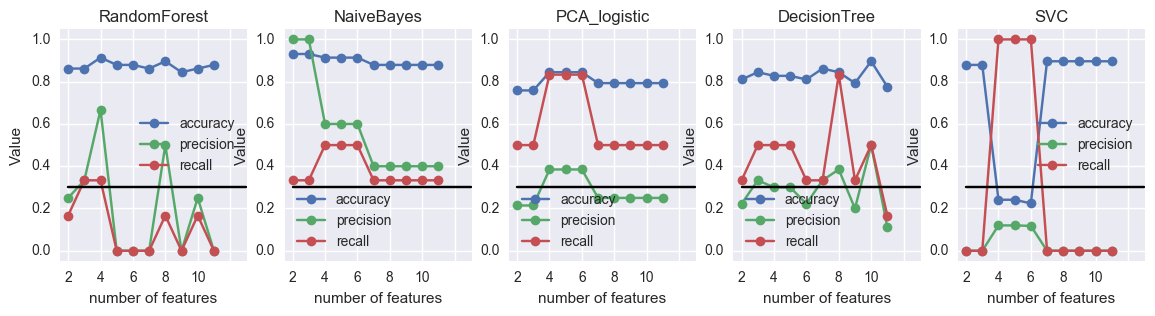

In [57]:
# process the data to array
target = df.poi.as_matrix()
features = df.drop('poi', axis=1).as_matrix()
# scale features
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)
# interested_list: features ordered by scores
interested_list, pd_score = select_features(df, scaled_features, target)
# calculate
out_pred = test_precision(dataset, interested_list)
plot_value(out_pred)

In [32]:
print "This is the feature list for the processed data." 
print "The feature list is ordered from the best score to the worst score using SelectKBest."
print "The features included in the test above were added according to the order presented here."
print 
print interested_list

This is the feature list for the processed data.
The feature list is ordered from the best score to the worst score using SelectKBest.
The features included in the test above were added according to the order presented here.

['exercised_stock_options', 'total_stock_value', 'to_poi', 'bonus', 'salary', 'restricted_stock', 'total_payments', 'shared_receipt_with_poi', 'other', 'from_poi', 'expenses']


** Naive Bayes overall shows the best performance, suggesting that a good feature selection process is also important in machine learning. No matter how many features are used, the performance always reached our standard (both precission and recall should greater than 0.3.) PCA followed by logistic regreesion also did a pretty good job around using the first 4-6 features. Considering 'exercised_stock_options' and 'bonus' already show better performance than the other methods. Precision can be further improved 20% after including 'restricted_stock'. Further addition of 'Total_payment'increases the precision but decrease the recall to our bottom line (0.3). Decision Tree also performs pretty well with >8 features used. It's quite strange to me that the regions SVC show better precision and recalls actuaaly show very low accuracy. The bad performance of these more complicated methods is probably due to the very few poi in the dataset. As the behavior of different pois can also be quite different, the likelihood to "group" them together also decreases, resulting in the low performance of Decision Tree, RandomForest and SVM. **

### Analyze the performance of the original data (data without processing)

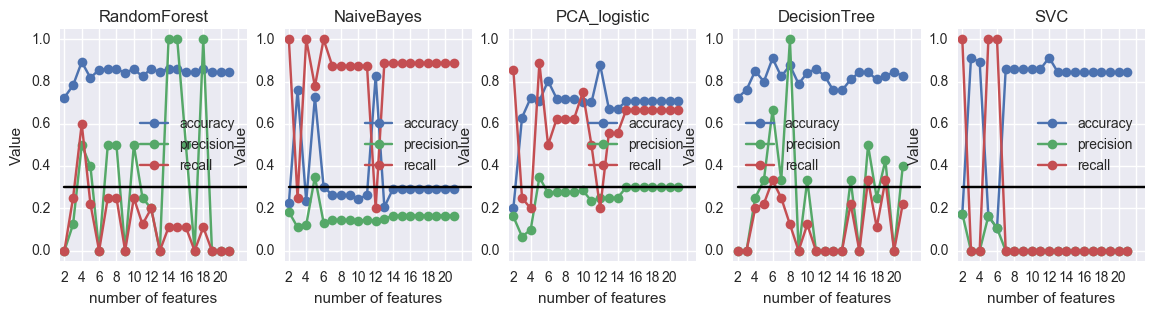

In [371]:
# no special interested_list so don't input
out_pred_ori = test_precision(df_ori, df2_list)
plot_value(out_pred_ori)

In [374]:
print "This is the list of all features in the original dataset."
print "The features included in the test above were added according to the order presented here."
print 
print df2_list

This is the list of all features in the original dataset.
The features included in the test above were added according to the order presented here.

['bonus', 'deferral_payments', 'deferred_income', 'director_fees', 'exercised_stock_options', 'expenses', 'from_messages', 'from_poi_to_this_person', 'from_this_person_to_poi', 'loan_advances', 'long_term_incentive', 'other', 'restricted_stock', 'restricted_stock_deferred', 'salary', 'shared_receipt_with_poi', 'to_messages', 'total_payments', 'total_stock_value', 'to_poi', 'from_poi']


**The performace of original data rarely reached our standard (both precision and recall >0.3), suggesting the analysis for processing the data improved the performance of machine learning. To further examine the importance of feature selection as well as compare the performance of my data processing, I next run the machine learning with feature list selected with SelectKBest. **

### Analyze the performance of original data but features are selected accroding to their scores in SelectKBest

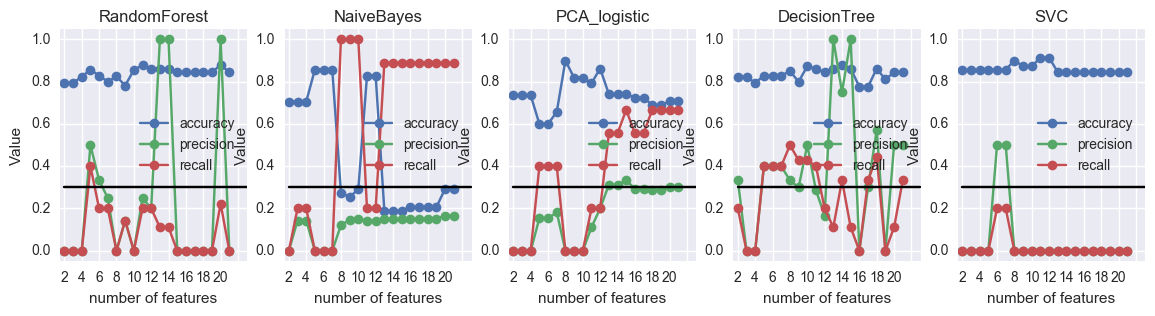

In [376]:
# process the data to array
df2_target = df2.poi.as_matrix()
df2_features = df2.drop('poi', axis=1).as_matrix()

# scale features
scaler = MinMaxScaler()
df2_scaled_features = scaler.fit_transform(df2_features)
# interested_list: features ordered by scores
interested_list_df2, pd_score_df2 = select_features(df2, df2_scaled_features, df2_target)
out_pred_ori_df2 = test_precision(df_ori, interested_list_df2)
plot_value(out_pred_ori_df2)

In [377]:
print "This is the feature list for this data." 
print "The feature list is ordered from the best score to the worst score using SelectKBest."
print "The features included in the test above were added according to the order presented here."
print
print interested_list_df2

This is the feature list for this data.
The feature list is ordered from the best score to the worst score using SelectKBest.
The features included in the test above were added according to the order presented here.

['to_poi', 'shared_receipt_with_poi', 'from_poi_to_this_person', 'from_poi', 'loan_advances', 'from_this_person_to_poi', 'to_messages', 'director_fees', 'total_payments', 'deferral_payments', 'exercised_stock_options', 'deferred_income', 'total_stock_value', 'from_messages', 'bonus', 'other', 'restricted_stock', 'long_term_incentive', 'expenses', 'restricted_stock_deferred', 'salary']


**The performance seems to increase a little bit by including the features in a pre-selected order. However, the performace of the data I processed above still perform much better, suggesting the important role of analyzing and pre-processing data in machine learning.**

# Explore certain fields
**Out of curiousity, I want to know if we can reach better performance by selecting features contains similar information. Probably we can also gain some insight about what kind of information is most critical to identify poi.**
**The workflow is:**

>1. Use `get_scores_df` to calculate the performance of all different interested feature lists.
>2. Use `plot_scores` to plot the performance of different feature list and different machine learning methods. 

## Functions

In [281]:
def get_best_clf(dataset, features_list):
    num = len(features_list)
    
    
    # data
    data = featureFormat(dataset, features_list, sort_keys = True)
    labels, features = targetFeatureSplit(data)
    features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.4, random_state=42)
            
    
    # pipeline for PCA- logistic
    logistic = linear_model.LogisticRegression()
    pca = decomposition.PCA()
    pipe = Pipeline(steps=[('pca', pca), ('logistic', logistic)])
    
    # Fit estimators
    ESTIMATORS = {
        "NaiveBayes": GaussianNB(),
        "SVC": SVC(kernel='rbf', class_weight='balanced'), 
        "DecisionTree": DecisionTreeClassifier(max_depth=None),
        "RandomForest": RandomForestClassifier(max_depth=None),
        "PCA_logistic": pipe
    }

    # set parameter grids:
    # SVC: 
    C_range = np.logspace(-3, 7, 11)
    gamma_range = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
    # DecisionTree:
    # max_features = [int(np.floor(np.sqrt(n_feature))), 3]
    max_features = range(2, num) 
#     print max_features
    min_samples_split = [3, 5, 8, 14, 18, 25]
    ## RandomForest:
    n_estimators = [10, 30, 50]
#     max_features = [int(np.floor(np.sqrt(num))), num]
    # PCA
    n_components = range(1, num)
    Cs = np.logspace(-4, 4, 3)
        
    param_grid = {
    "NaiveBayes":dict(),
    "SVC" : dict(gamma=gamma_range, C=C_range),
    "DecisionTree" : dict(max_features=max_features, min_samples_split=min_samples_split),
    "RandomForest" : dict(n_estimators=n_estimators, max_features=max_features, min_samples_split=min_samples_split),  
    "PCA_logistic" : dict(pca__n_components=n_components,logistic__C=Cs)
    }

    ListBestPara = dict()
    ListScore = dict()
    ListPred = dict()
    ListPrecision = dict()
    ListAcc = dict()
    ListRecall = dict()

    for name, estimator in ESTIMATORS.items():
#         print name
        clf = GridSearchCV(estimator, param_grid[name], cv=5)
        clf.fit(features_train, labels_train)
        ListBestPara[name] = clf.best_estimator_
        predictions = clf.predict(features_test)
        ListPred[name] = predictions
        ListScore[name] = clf.best_estimator_.score(features_test,labels_test)
        # precision
        ListPrecision[name] = precision_score(labels_test,predictions)
        ListRecall[name] = recall_score(labels_test,predictions)
        ListAcc[name] = accuracy_score(predictions,labels_test)

#     print ListScore
#     print ListBestPara
    
#     print '==========='
#     print "precision"
#     print ListPrecision
#     print
#     print 'recall'
#     print ListRecall
#     print 
#     print 'Accuracy'
#     print ListAcc

    return ListPrecision, ListRecall, ListAcc
    
    
def get_scores_df(dataset, all_list, all_test_names):
    dict_precision = []
    dict_recall = []
    dict_acc = []
    
    for examined_list in all_list:
        ListPrecision, ListRecall, ListAcc = get_best_clf(dataset, examined_list)
        dict_precision.append(ListPrecision)
        dict_recall.append(ListRecall)
        dict_acc.append(ListAcc)
    
    # combine to a data frame
    df_precision = pd.DataFrame(dict_precision, index=all_test_names).transpose().reset_index()
    melt_df_precision = pd.melt(df_precision, id_vars='index')
    df_recall = pd.DataFrame(dict_recall, index=all_test_names).transpose().reset_index()
    melt_df_recall = pd.melt(df_recall, id_vars='index')
    df_acc = pd.DataFrame(dict_acc, index=all_test_names).transpose().reset_index()
    melt_df_acc = pd.melt(df_acc, id_vars='index')    
    
    return melt_df_precision, melt_df_recall, melt_df_acc

def plot_scores(method_names, melt_df_precision, melt_df_recall, melt_df_acc):
# plot
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))
    g = sns.barplot(x='index', y='value', data=melt_df_precision, hue='variable', ax = ax1)
    g.set(xlabel='', ylabel='Precision', title='Precision of different methods and features');
    g.set(ylim=[0,1], yticks=np.arange(0.1, 1.2, 0.2))
    ax1.legend_.remove()
    g.set_xticklabels(method_names, rotation=90)
    g = sns.barplot(x='index', y='value', data=melt_df_recall, hue='variable', ax = ax2)
    g.set(xlabel='', ylabel='Recall', title='Recall of different methods and features');
    g.set(ylim=[0,1], yticks=np.arange(0.1,1.2,0.2))
    g.set_xticklabels(method_names, rotation=90)
    g = sns.barplot(x='index', y='value', data=melt_df_acc, hue='variable', ax = ax3)
    g.set(xlabel='', ylabel='Accurracy', title='Accurracy of different methods and features');
    g.set_xticklabels(method_names, rotation=90)
    g.set(ylim=[0,1], yticks=np.arange(0.1,1.2,0.2))
    ax3.legend_.remove()

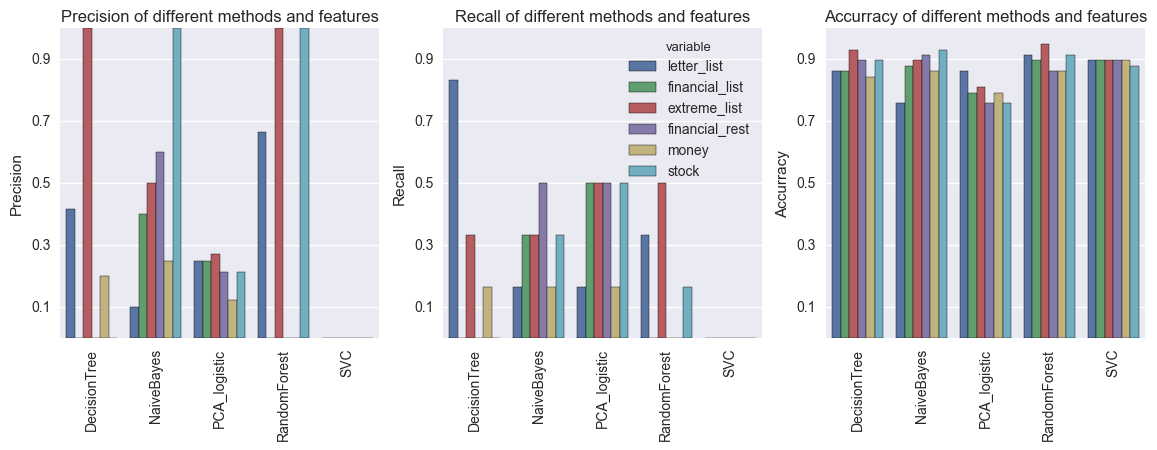

In [282]:
# all lists
method_names= ['DecisionTree', 'NaiveBayes', 'PCA_logistic', 'RandomForest', 'SVC']
letter_list = ['poi','to_poi','from_poi','shared_receipt_with_poi']
financial_list = ['poi','bonus', 'exercised_stock_options', 'expenses', 'restricted_stock', 'salary', 'total_payments', 'total_stock_value']
extreme_list = ['poi','total_payments', 'total_stock_value','other']
financial_rest = ['poi','bonus', 'exercised_stock_options', 'expenses', 'restricted_stock', 'salary']
stock = ['poi','exercised_stock_options', 'restricted_stock', 'total_stock_value']
money = ['poi','salary', 'total_payments', 'bonus']
all_list = [letter_list, financial_list, extreme_list, financial_rest, money, stock]
all_test_names = ['letter_list', 'financial_list', 'extreme_list', 'financial_rest', 'money', 'stock']

# function
# get data frame
melt_df_precision, melt_df_recall, melt_df_acc = get_scores_df(dataset, all_list, all_test_names)
# plot
plot_scores(method_names, melt_df_precision, melt_df_recall, melt_df_acc)

**Extreme_list and financial list seem to show better performance than the rest. Extreme_list is the list that a few people show extreme high values than others ('total_payments', 'total_stock_value','other') Financial_rest ('bonus', 'exercised_stock_options', 'expenses', 'restricted_stock', 'salary') is features excluding letter information ('to_poi', 'from_poi', 'shared_recipt_with_poi') and extrem_list. **

# Evaluate the effect from new created features: from_poi & to_poi
To examine the effect of newly creaed features "from_poi" and "to_poi" on the performance of the final algorithms, I will compare the precision, recall and accuracy using features in the "interested_list" with the features in "no_new_interested_list" (i.e., interested_list excluding "from_poi" and "to_poi").  


## Functions

In [42]:
### get the precisoin, recall, accuracy for different amount of test data
def examine_new_feature(clf, dataset, feature_list):
   
    data = featureFormat(dataset, ['poi']+feature_list, sort_keys = True)
    labels, features = targetFeatureSplit(data)
    features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.4, random_state=42)
        
    # classifier
    clf.fit(features_train, labels_train)
    predictions = clf.predict(features_test)

    # calculate
    pre = precision_score(labels_test,predictions)
    recall = recall_score(labels_test,predictions)
    acc = accuracy_score(predictions,labels_test)
        
    return pre, recall, acc

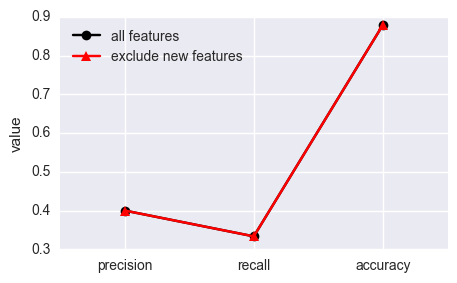

In [56]:
no_new_interested_list = ['exercised_stock_options', 'total_stock_value', 'bonus', 
                          'salary', 'restricted_stock', 'total_payments', 'shared_receipt_with_poi', 
                          'other', 'expenses']

clf = GaussianNB()
test_list = np.arange(0.1, 0.9, 0.05)

labels = ['precision', 'recall', 'accuracy']
y = examine_new_feature(clf, dataset, interested_list)
ny = examine_new_feature(clf, dataset, no_new_interested_list)

px = range(3)
plt.figure(figsize=(5,3))
plt.plot(px, y, 'ko-')
plt.plot(px, ny, 'r^-')
plt.xticks(px, labels)
plt.ylabel('value')
plt.xlim([-0.5,2.5])
plt.legend(['all features','exclude new features'],loc=2);

**It seems like simply including the new features "form_poi" and "to_poi" won't affect the performance. We need a better feature selection method.**

# Final Decision

- Method Selected: Gaussian Naive Bayes 
- Features Selected: 'exercised_stock_options', 'total_stock_value', 'to_poi', 'bonus', 'salary', 'restricted_stock'

**The workflow will be:**
>1. Use `examine_test_percent` to tune the percentage of data used for test.
>2. Compare the performance of the first 4 - 6 features using different percentage test data, as they ar eshow the >same in our first test above. 
>3. If I didn't choose the parameter-free Naive Bayes method, then I will run a more detail parameter search to tune >the best parameters. 

## Functions

In [334]:
### get the precisoin, recall, accuracy for different amount of test data
def examine_test_percent(clf, dataset, feature_list, test_list):
    pre = []
    recall = []
    acc = []
    
    for t_in in test_list:
        data = featureFormat(dataset, ['poi']+feature_list, sort_keys = True)
        labels, features = targetFeatureSplit(data)
        features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=t_in, random_state=42)
        
        # classifier
        clf.fit(features_train, labels_train)
        predictions = clf.predict(features_test)

        # calculate
        pre.append(precision_score(labels_test,predictions))
        recall.append(recall_score(labels_test,predictions))
        acc.append(accuracy_score(predictions,labels_test))
        
    return pre, recall, acc

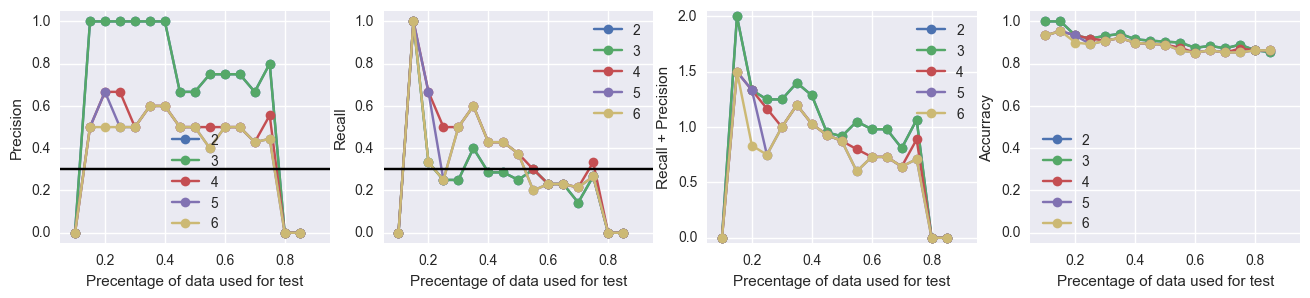

In [335]:
clf = GaussianNB()
test_list = np.arange(0.1, 0.9, 0.05)

# test for different number of features
list_feature_num = range(2,7)
allpre = []
allcall = []
allacc = []
for num in list_feature_num:
    pre, recall, acc = examine_test_percent(clf, dataset, interested_list[:num], test_list)
    allpre.append(pre)
    allcall.append(recall)
    allacc.append(acc)
df_pre = pd.DataFrame(allpre, index = list_feature_num, columns = test_list).transpose()
df_call = pd.DataFrame(allcall, index = list_feature_num, columns = test_list).transpose()
df_acc = pd.DataFrame(allacc, index = list_feature_num, columns = test_list).transpose()

# plot
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16,3))
g = df_pre.plot(linestyle='-', marker='o', ax = ax1)
g.plot([0,(len(test_list)+1)],[0.3,0.3],'k-')
g.set(xlim=[0.05,0.95], ylim=[-0.05, 1.05], xlabel='Precentage of data used for test', ylabel='Precision');

g = df_call.plot(linestyle='-', marker='o', ax = ax2)
g.set(xlim=[0.05,0.95], ylim=[-0.05, 1.05], xlabel='Precentage of data used for test', ylabel='Recall');
g.plot([0,(len(test_list)+1)],[0.3,0.3],'k-')

g = (df_call+df_pre).plot(linestyle='-', marker='o', ax = ax3)
g.set(xlim=[0.05,0.95], ylim=[-0.05, 2.05], xlabel='Precentage of data used for test', ylabel='Recall + Precision');

g = df_acc.plot(linestyle='-', marker='o', ax = ax4)
g.set(xlim=[0.05,0.95], ylim=[-0.05, 1.05], xlabel='Precentage of data used for test', ylabel='Accurracy');


In [378]:
print "This is the feature list for the processed data." 
print "The feature list is ordered from the best score to the worst score using SelectKBest."
print "The features included in the test above were added according to the order presented here."
print
print interested_list

This is the feature list for the processed data.
The feature list is ordered from the best score to the worst score using SelectKBest.
The features included in the test above were added according to the order presented here.

['exercised_stock_options', 'total_stock_value', 'to_poi', 'bonus', 'salary', 'restricted_stock', 'total_payments', 'shared_receipt_with_poi', 'other', 'from_poi', 'expenses']


** It seems like using 0.15 percent data for testing, 3 features: 'exercised_stock_options', 'total_stock_value', 'to_poi' can lead to "Precesion = 1",  "Recall = 1", and overall, "Accuracy = 1". However, the performace highly depends on the amount of training and dataset (i.e., highly depends on the data, as we make sure we always use the same data for testing and training by setting random_state=42). To make sure my final selection of features will pass the tester from Udacity, I am going to examine the performance of different number of features (3-6) from my current feature list and choose the best to report. **

In [349]:
from tester import test_classifier
for num in [3, 4, 5, 6]:
    final_list = ['poi'] + interested_list[:num]
    print "feature number =", num
    print "---------------------------"
    test_classifier(clf, dataset, final_list, folds = 1000)

feature number = 3
---------------------------
GaussianNB(priors=None)
	Accuracy: 0.85760	Precision: 0.44612	Recall: 0.28150	F1: 0.34519	F2: 0.30393
	Total predictions: 15000	True positives:  563	False positives:  699	False negatives: 1437	True negatives: 12301

feature number = 4
---------------------------
GaussianNB(priors=None)
	Accuracy: 0.85353	Precision: 0.43608	Recall: 0.33600	F1: 0.37955	F2: 0.35216
	Total predictions: 15000	True positives:  672	False positives:  869	False negatives: 1328	True negatives: 12131

feature number = 5
---------------------------
GaussianNB(priors=None)
	Accuracy: 0.85807	Precision: 0.45621	Recall: 0.33600	F1: 0.38699	F2: 0.35469
	Total predictions: 15000	True positives:  672	False positives:  801	False negatives: 1328	True negatives: 12199

feature number = 6
---------------------------
GaussianNB(priors=None)
	Accuracy: 0.86133	Precision: 0.47179	Recall: 0.33450	F1: 0.39146	F2: 0.35517
	Total predictions: 15000	True positives:  669	False positives

** As list "financial_rest" also show quite good performance, let's also run this to the list "financial_rest" before my final decision.**

In [379]:
for num in [3, 4, 5, 6]:
    final_list = ['poi'] + financial_rest[:num]
    print "feature number =", num
    print "---------------------------"
    test_classifier(clf, dataset, final_list, folds = 1000)

feature number = 3
---------------------------
GaussianNB(priors=None)
	Accuracy: 0.86333	Precision: 0.48041	Recall: 0.30650	F1: 0.37424	F2: 0.33042
	Total predictions: 15000	True positives:  613	False positives:  663	False negatives: 1387	True negatives: 12337

feature number = 4
---------------------------
GaussianNB(priors=None)
	Accuracy: 0.86140	Precision: 0.46959	Recall: 0.30500	F1: 0.36981	F2: 0.32799
	Total predictions: 15000	True positives:  610	False positives:  689	False negatives: 1390	True negatives: 12311

feature number = 5
---------------------------
GaussianNB(priors=None)
	Accuracy: 0.86080	Precision: 0.46901	Recall: 0.33300	F1: 0.38947	F2: 0.35350
	Total predictions: 15000	True positives:  666	False positives:  754	False negatives: 1334	True negatives: 12246

feature number = 6
---------------------------
GaussianNB(priors=None)
	Accuracy: 0.84693	Precision: 0.40107	Recall: 0.30000	F1: 0.34325	F2: 0.31592
	Total predictions: 15000	True positives:  600	False positives

# Conclusion

**It seems like 6 features from my previous feature list show the best performance. Therefore, the final feature list I will submit is: 'exercised_stock_options', 'total_stock_value', 'to_poi', 'bonus', 'salary', 'restricted_stock'**

**Compare to the list of "financial_rest": 'bonus', 'exercised_stock_options', 'expenses', 'restricted_stock', 'salary', my list consider one information from "the interaction with poi (to_poi)" and one information about "extreme case (total_stock_value)" **

** Overall, we can say that the most critical features for identifying people involved in the fraud is the financial data. Actually these three factors ('bonus', 'exercised_stock_options', 'expenses') already enough to reach the best performance (Accuracy: 0.86, Precision: 0.48, Recall: 0.31). The additional consideration of emails that showing the interactions with poi only slightly improve the performance.**